In [1]:
library(ggplot2)
library(patchwork)
library(pROC)
library(ggnewscale)
library(JGL)
library(latex2exp)
options(warn=-1)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




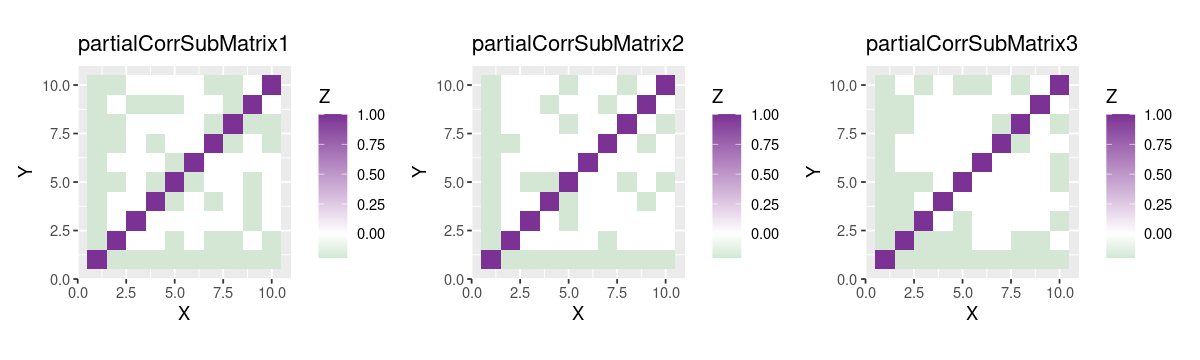

In [2]:
rm(list = ls())
source('../tools.R')
source('../FLAG.R')
set.seed(1)

get.pc.true <- function(p, sparsity, value=-0.2){
  sparse = rbinom(p*p,1,1-sparsity)*value
  pc = matrix(sparse, p, p)
  pc[,1] = value
  pc[upper.tri(pc)] = t(pc)[upper.tri(pc)]
  diag(pc) = 1
  pc
}

p=10
tmp1 = get.pc.true(p, 0.7)
options(repr.plot.width=10, repr.plot.height=3)
X=Y=1:p
df=expand.grid(X=X, Y=Y)
df$Z=c(tmp1)
p1=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('partialCorrSubMatrix1') + coord_fixed() +
      scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-0.2, 1))

tmp2 = get.pc.true(p, 0.7)
tmp3 = get.pc.true(p, 0.7)
df$Z=c(tmp2)
p2=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('partialCorrSubMatrix2') + coord_fixed() +
      scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-0.2, 1))
df$Z=c(tmp3)
p3=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('partialCorrSubMatrix3') + coord_fixed() +
      scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-0.2, 1))
p1+p2+p3

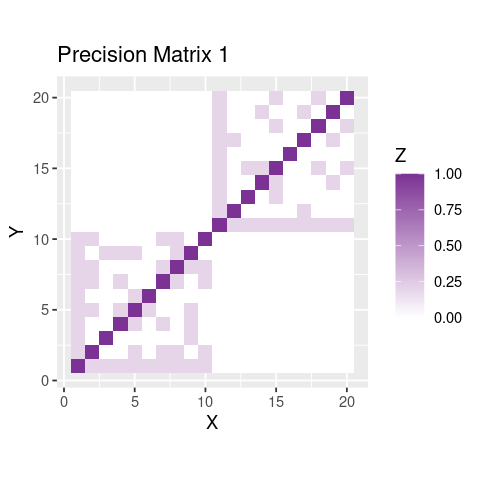

In [3]:
P = 2*p
sigma.list = c(rep(1,P))
pc1 = matrix(0, P, P)
pc1[1:p, 1:p] = tmp1
pc1[(p+1):P, (p+1):P] = tmp2
Pre1 = -diag(sigma.list) %*% pc1 %*% diag(sigma.list)
diag(Pre1) = -diag(Pre1)
options(repr.plot.width=4, repr.plot.height=4)
X=Y=1:P
df=expand.grid(X=X, Y=Y)
df$Z=c(Pre1)
ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('Precision Matrix 1') + coord_fixed() +
      scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(0, 1))

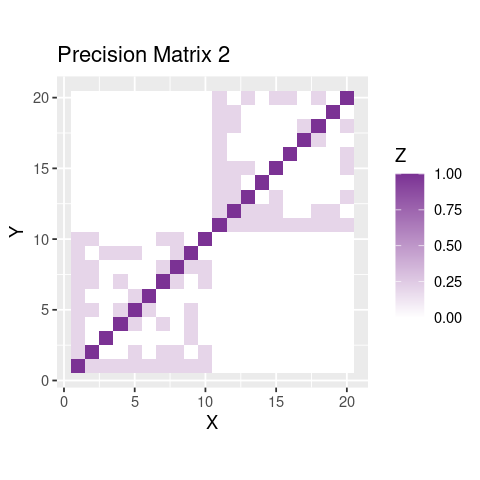

In [4]:
pc2 = matrix(0, P, P)
pc2[1:p, 1:p] = tmp1
pc2[(p+1):P, (p+1):P] = tmp3
Pre2 = -diag(sigma.list) %*% pc2 %*% diag(sigma.list)
diag(Pre2) = -diag(Pre2)
options(repr.plot.width=4, repr.plot.height=4)
X=Y=1:P
df=expand.grid(X=X, Y=Y)
df$Z=c(Pre2)
ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('Precision Matrix 2') + coord_fixed() +
      scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(0, 1))

In [5]:
Sigma1 = solve(Pre1)
Sigma2 = solve(Pre2)
Pre1.adj = get.adj(Pre1)
Pre2.adj = get.adj(Pre2)
N1 = 80
N2 = 120
Z1 = MASS::mvrnorm(N1, rep(0, P), Sigma1)
Z1 = scale(Z1, center = T, scale = F)
Z2 = MASS::mvrnorm(N2, rep(0, P), Sigma2)
Z2 = scale(Z2, center = T, scale = F)

In [6]:
glasso1 = run.glasso(Z1)
glasso1$lambda
glasso2 = run.glasso(Z2)
glasso2$lambda

[1] 0.06309573

[1] 0.06309573

In [7]:
om1 = OurMethod(Z1, infer='wald')
om2 = OurMethod(Z2, infer='wald')
fdr.thr = 0.15

In [8]:
test.pval.list = c()
meta.pval.list = c()
res = NULL
om.meta.rho = matrix(0, P, P)
om.meta.rho.se = matrix(0, P, P)
om.meta.rho.pval = matrix(0, P, P)
om.meta.prec1 = diag( diag(om1$precision.est) )
om.meta.prec2 = diag( diag(om2$precision.est) )
for(i in 1:(P-1)){
  for(j in (i+1):P){
    rho1 = om1$rho.est[i,j]
    rho2 = om2$rho.est[i,j]
    rho.se1 = om1$rho.se[i,j]
    rho.se2 = om2$rho.se[i,j]
    rho.pval1 = om1$partialcor.pval[i,j]
    rho.pval2 = om2$partialcor.pval[i,j]
    test.stat = (rho1 - rho2) / sqrt( rho.se1^2 + rho.se2^2 )
    test.pval = pchisq(test.stat^2, 1, lower.tail = F)
    test.pval.list = c(test.pval.list, test.pval)
    if(is.na(test.pval)==TRUE | test.pval<0.05){
      meta.rho = NaN
      meta.rho.se = NaN
      meta.rho.pval = NaN
      om.meta.prec1[i,j] = om.meta.prec1[j,i] = om1$precision.est[i,j]
      om.meta.prec2[i,j] = om.meta.prec2[j,i] = om2$precision.est[i,j]
    }
    else{
      rho.list = c(rho1, rho2)
      w.list = c( 1/(rho.se1^2), 1/(rho.se2^2) )
      w.sum = sum(w.list)
      meta.rho = sum(w.list * rho.list) / w.sum
      meta.rho.se = 1 / sqrt(w.sum)
      meta.rho.pval = pchisq((meta.rho / meta.rho.se)^2, 1, lower.tail = F)
      eta1 = meta.rho * sqrt(om1$sigma.a2[i,j]) * sqrt(om1$sigma.b2[i,j])
      eta2 = meta.rho * sqrt(om2$sigma.a2[i,j]) * sqrt(om2$sigma.b2[i,j])
      prec1 = solve( matrix(c(om1$sigma.a2[i,j], eta1, eta1, om1$sigma.b2[i,j]), 2, 2) )
      prec2 = solve( matrix(c(om2$sigma.a2[i,j], eta2, eta2, om2$sigma.b2[i,j]), 2, 2) )
      om.meta.prec1[i,j] = om.meta.prec1[j,i] = prec1[1,2]
#       cat('om1', om1$precision.est[i,j], prec1[1,2])
      om.meta.prec2[i,j] = om.meta.prec2[j,i] = prec2[1,2]
#       cat('\tom2', om2$precision.est[i,j], prec2[1,2], '\n')
    }
    om.meta.rho[i,j] = om.meta.rho[j,i] = meta.rho
    om.meta.rho.se[i,j] = om.meta.rho.se[j,i] = meta.rho.se
    om.meta.rho.pval[i,j] = om.meta.rho.pval[j,i] = meta.rho.pval
    meta.pval.list = c(meta.pval.list, meta.rho.pval)
    
    res0 = data.frame(i, j, Pre1.adj[i,j], Pre2.adj[i,j],
                      rho1, rho2, rho.se1, rho.se2, rho.pval1, rho.pval2,
                      test.stat, test.pval,
                      meta.rho, meta.rho.se, meta.rho.pval
                     )
    res = rbind(res, res0)
  }
}
colnames(res) = c("i", "j", "adj1.true", "adj2.true",
                  "rho.1", "rho.2", "rho.se1", "rho.se2", "rho.pval1", "rho.pval2",
                  "test.stat", "test.pval",
                  "rho.meta", "meta.rho.se", "meta.rho.pval")

In [9]:
om.edge1 = get.fdr(om1$precision.pval, thr=fdr.thr, diag.val=1)
om.edge2 = get.fdr(om2$precision.pval, thr=fdr.thr, diag.val=1)

om.meta.edge = get.fdr(om.meta.rho.pval, thr=fdr.thr, diag.val=1)
om.meta.edge1 = om.meta.edge
om.meta.edge1[ which(is.na(om.meta.edge1)) ] = om.edge1[ which(is.na(om.meta.edge1)) ]
om.meta.edge2 = om.meta.edge
om.meta.edge2[ which(is.na(om.meta.edge2)) ] = om.edge2[ which(is.na(om.meta.edge2)) ]

# QQplot that splits null cases and alternative cases

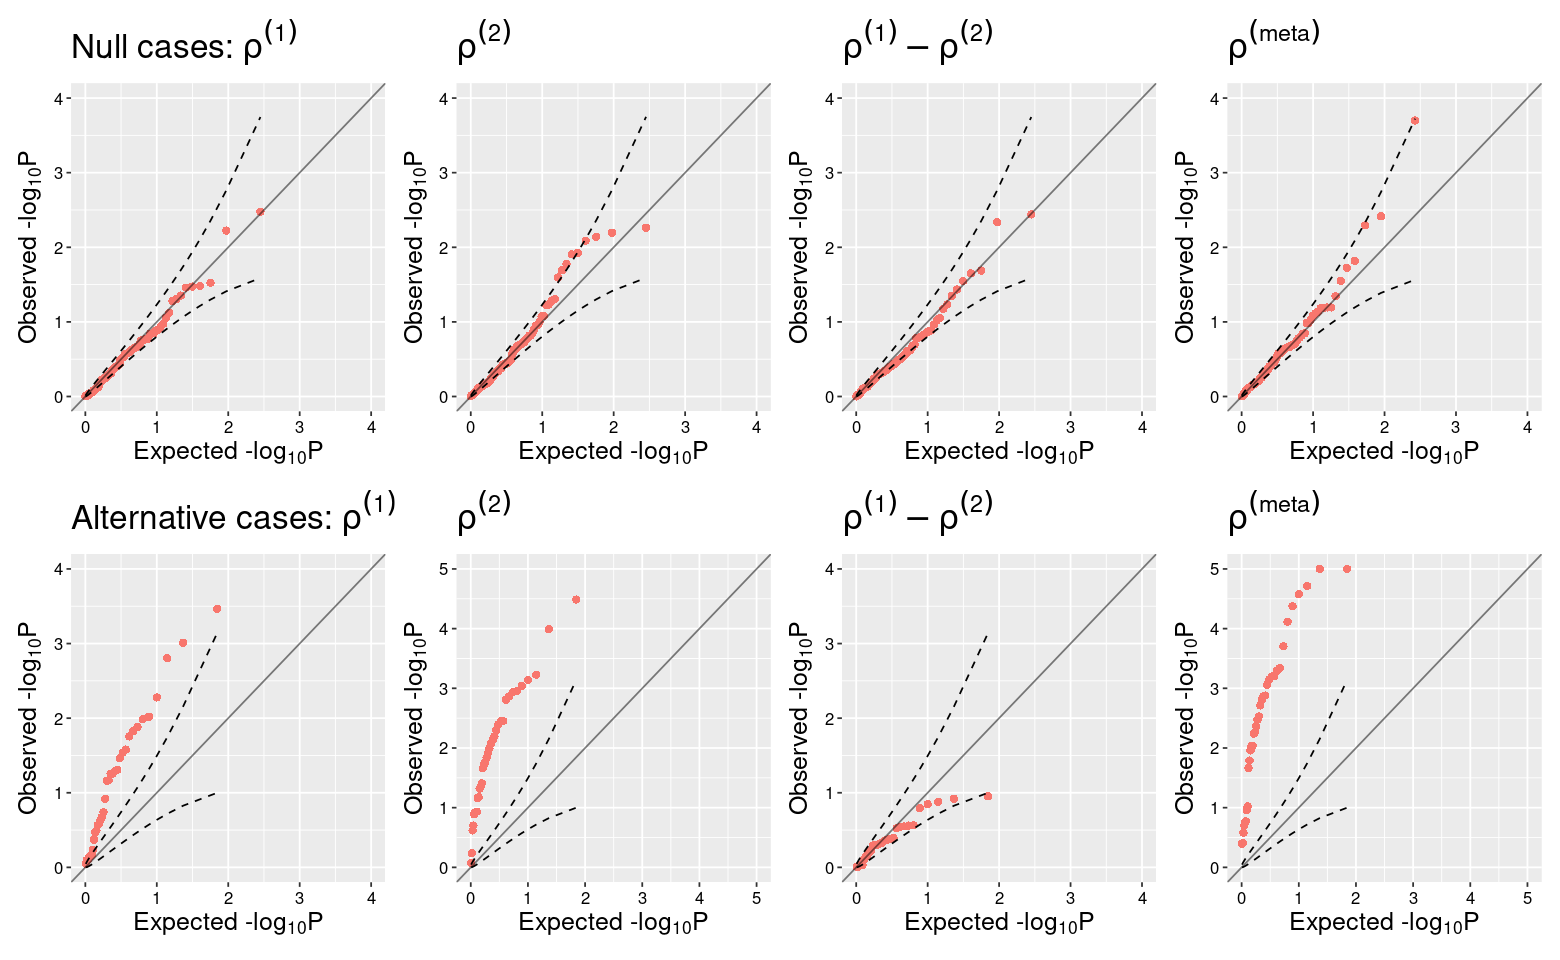

In [10]:
res.null = subset(res, adj1.true==0&adj2.true==0)
res.alter = subset(res, adj1.true==1&adj2.true==1)

options(repr.plot.width=13, repr.plot.height=8)
# qqplot1(res.null, 'rho.pval1', max=4) + ggtitle(TeX("Null cases: $\\rho^{(1)}$")) +
qqplot1(na.omit(res.null['rho.pval1']), 'rho.pval1', max=4) + ggtitle(TeX("Null cases: $\\rho^{(1)}$")) +
qqplot1(res.null, 'rho.pval2', max=4) + ggtitle(TeX("$\\rho^{(2)}$")) +
# qqplot1(res.null, 'test.pval', max=4) + ggtitle(TeX("$\\rho^{(1)} - \\rho^{(2)}$")) +
qqplot1(na.omit(res.null['test.pval']), 'test.pval', max=4) + ggtitle(TeX("$\\rho^{(1)} - \\rho^{(2)}$")) +
qqplot1(na.omit(res.null), 'meta.rho.pval', max=4) + ggtitle(TeX("$\\rho^{(meta)}$")) +

qqplot1(res.alter, 'rho.pval1', max=4) + ggtitle(TeX("Alternative cases: $\\rho^{(1)}$")) +
qqplot1(res.alter, 'rho.pval2') + ggtitle(TeX("$\\rho^{(2)}$")) +
qqplot1(res.alter, 'test.pval', max=4) + ggtitle(TeX("$\\rho^{(1)} - \\rho^{(2)}$")) +
# qqplot1(na.omit(res.alter['test.pval']), 'test.pval', max=4) + ggtitle(TeX("$\\rho^{(1)} - \\rho^{(2)}$")) +
qqplot1(na.omit(res.alter), 'meta.rho.pval') + ggtitle(TeX("$\\rho^{(meta)}$")) + plot_layout(ncol = 4)

In [11]:
jgl.fused = run.jgl(list(Z1,Z2), penalty='fused', lam.list=10^seq(-0.3, 1.1, 0.1))
jgl.fused$lam1
jgl.fused$lam2

[1] 12.58925

[1] 3.162278

In [12]:
jgl.group = run.jgl(list(Z1,Z2), penalty='group', lam.list=10^seq(-0.1, 0.9, 0.1))
jgl.group$lam1
jgl.group$lam2

[1] 7.943282

[1] 7.943282

In [13]:
get.heatmap<-function(Z, bound1=-0.2, bound2=0.49, title){
  diag(Z)=0
  df$Precision=c(Z)
  ggplot(df, aes(X, Y, fill= Precision)) + geom_tile(aes(fill = Precision)) + ggtitle(title) + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(bound1, bound2)) +
    xlab(NULL) + ylab(NULL)
}

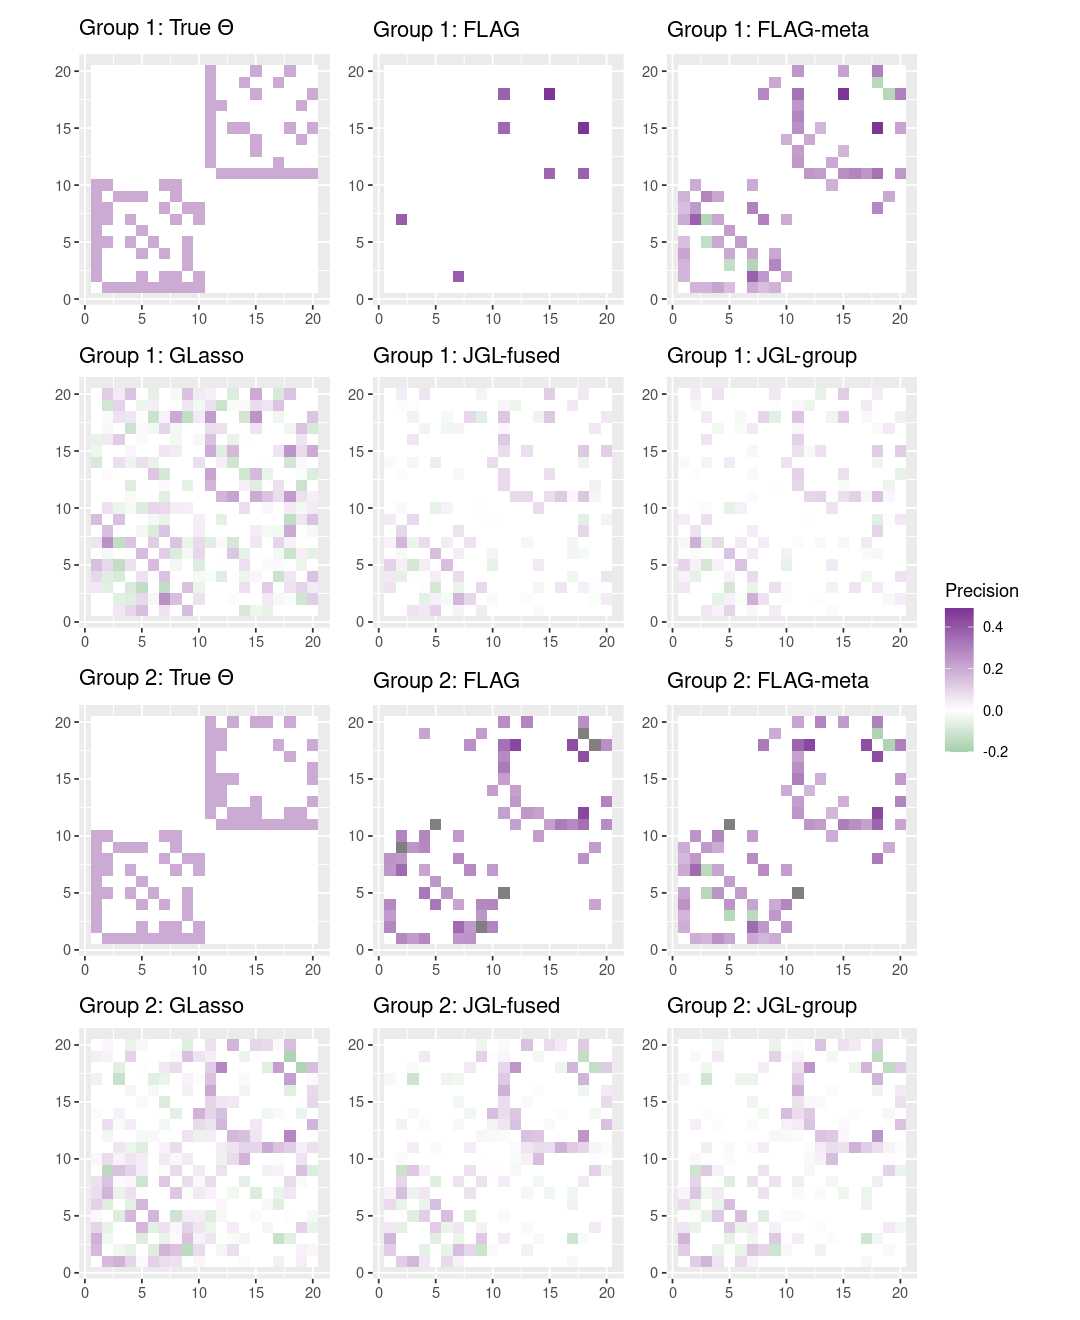

In [14]:
# layout for thesis
options(repr.plot.width=9, repr.plot.height=11)
X=Y=1:P
df=expand.grid(X=X, Y=Y)

p1=get.heatmap(Pre1, title=TeX("Group 1: True $\\Theta$"))
p2=get.heatmap(om1$precision.est * om.edge1, title='Group 1: FLAG')
p3=get.heatmap(om.meta.prec1 * om.meta.edge1, title='Group 1: FLAG-meta')
p4=get.heatmap(glasso1$wi, title='Group 1: GLasso')
p5=get.heatmap(jgl.fused$theta[[1]], title='Group 1: JGL-fused')
p6=get.heatmap(jgl.group$theta[[1]], title='Group 1: JGL-group')

p7=get.heatmap(Pre2, title=TeX("Group 2: True $\\Theta$"))
p8=get.heatmap(om2$precision.est * om.edge2, title='Group 2: FLAG')
p9=get.heatmap(om.meta.prec2 * om.meta.edge2, title='Group 2: FLAG-meta')
p10=get.heatmap(glasso2$wi, title='Group 2: GLasso')
p11=get.heatmap(jgl.fused$theta[[2]], title='Group 2: JGL-fused')
p12=get.heatmap(jgl.group$theta[[2]], title='Group 2: JGL-group')

p1+p2+p3+p4+p5+p6+p7+p8+p9+p10+p11+p12+ plot_layout(ncol = 3) + plot_layout(guides = "collect")

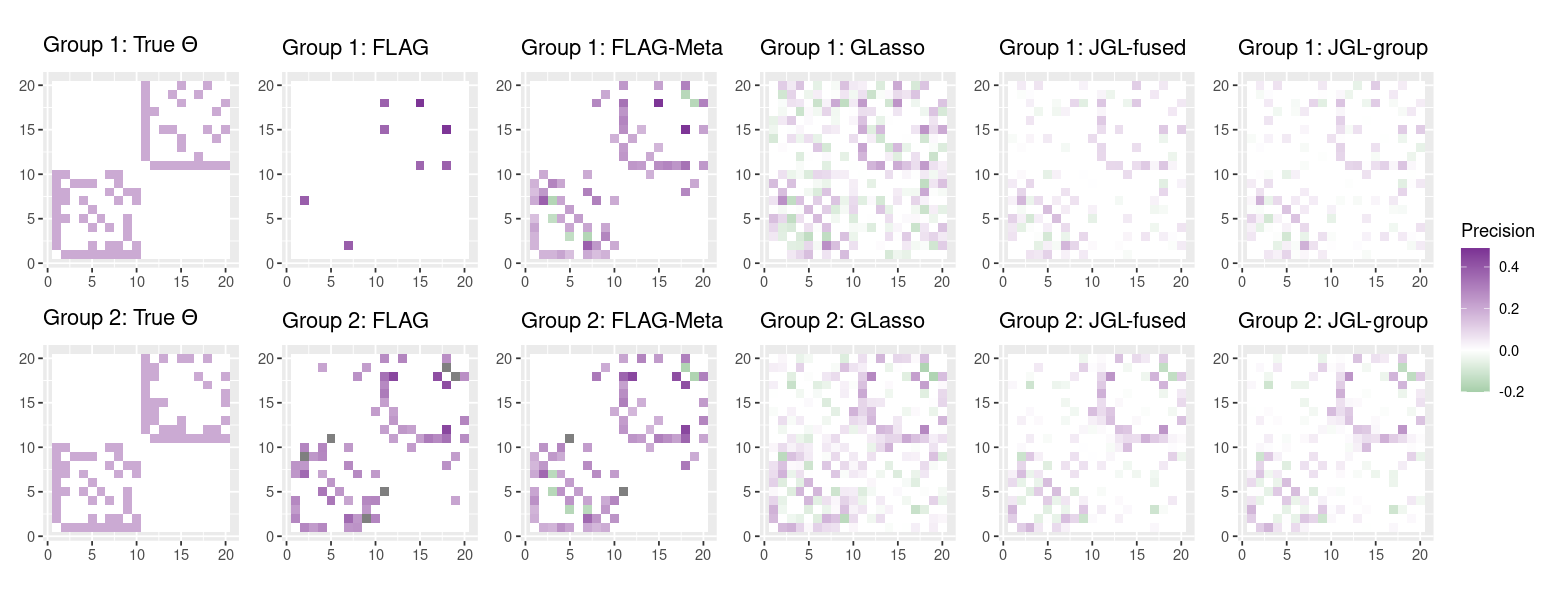

In [15]:
# layout for slides
options(repr.plot.width=13, repr.plot.height=5)
X=Y=1:P
df=expand.grid(X=X, Y=Y)

p1=get.heatmap(Pre1, title=TeX("Group 1: True $\\Theta$"))
p2=get.heatmap(om1$precision.est * om.edge1, title='Group 1: FLAG')
p3=get.heatmap(om.meta.prec1 * om.meta.edge1, title='Group 1: FLAG-Meta')
p4=get.heatmap(glasso1$wi, title='Group 1: GLasso')
p5=get.heatmap(jgl.fused$theta[[1]], title='Group 1: JGL-fused')
p6=get.heatmap(jgl.group$theta[[1]], title='Group 1: JGL-group')

p7=get.heatmap(Pre2, title=TeX("Group 2: True $\\Theta$"))
p8=get.heatmap(om2$precision.est * om.edge2, title='Group 2: FLAG')
p9=get.heatmap(om.meta.prec2 * om.meta.edge2, title='Group 2: FLAG-Meta')
p10=get.heatmap(glasso2$wi, title='Group 2: GLasso')
p11=get.heatmap(jgl.fused$theta[[2]], title='Group 2: JGL-fused')
p12=get.heatmap(jgl.group$theta[[2]], title='Group 2: JGL-group')

p1+p2+p3+p4+p5+p6+p7+p8+p9+p10+p11+p12+ plot_layout(ncol = 6) + plot_layout(guides = "collect")